<a href="https://colab.research.google.com/github/LinaDanilina/recommender-system/blob/master/deep_ctr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep CTR (Attention and Self-attention)

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [2]:
! ls
%cd drive/My Drive/DeepCTR-Torch

drive  sample_data
/content/drive/My Drive/DeepCTR-Torch


In [3]:
import numpy as np
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from deepctr_torch.models import DeepFM
import math
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    explained_variance_score,
    roc_auc_score,
    log_loss,
    ndcg_score
)
import sklearn
import time

DeepCTR-PyTorch version 0.2.1 detected. Your version is 0.2.0.
Use `pip install -U deepctr-torch` to upgrade.Changelog: https://github.com/shenweichen/DeepCTR-Torch/releases/tag/v0.2.1


In [4]:
# pass in column names for each CSV
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('u.user', sep='|', names=u_cols)

r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('u.data', sep='\t', names=r_cols)

# the movies file contains columns indicating the movie's genres
# let's only load the first five columns of the file with usecols
m_cols = ['movie_id', 'title', 'release_date', 'imdb_url']
movies = pd.read_csv('u.item', sep='|', names=['movie_id', 'movie_title', 'release_date', 'video_release_date', 'IMDb_URL', 
                                                  'unknown', 'Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime',
                                                  'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery',
                                                  'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'],
                     dtype={'release_date': "S100", 'imdb_url': "S200"},encoding = "ISO-8859-1")
genres = ['unknown', 'Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime',
          'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery',
          'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

movies['genre'] = movies[genres].idxmax(1)
#movies = movies.drop(genres, axis=1)
genres_encoder = sklearn.preprocessing.MultiLabelBinarizer()
movies['genre'] = genres_encoder.fit_transform(
        movies['genre'].apply(lambda s: s.split("|"))
    ).tolist()
    
# create one merged DataFrame
movie_ratings = pd.merge(movies[['movie_id', 'movie_title', 'release_date', 'video_release_date', 'IMDb_URL','genre']], ratings)
#data = pd.merge(movie_ratings, users)
data=pd.read_csv('data.csv')
data.head()

,Unnamed: 0,movie_id,movie_title,release_date,video_release_date,IMDb_URL,genre,user_id,rating,unix_timestamp,age,sex,occupation,zip_code
0,0,1,Toy Story (1995),b'01-Jan-1995',NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",308,4,887736532,60,M,retired,95076
1,1,4,Get Shorty (1995),b'01-Jan-1995',NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",308,5,887737890,60,M,retired,95076
2,2,5,Copycat (1995),b'01-Jan-1995',NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",308,4,887739608,60,M,retired,95076
3,3,7,Twelve Monkeys (1995),b'01-Jan-1995',NaN,http://us.imdb.com/M/title-exact?Twelve%20Monk...,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",308,4,887738847,60,M,retired,95076
4,4,8,Babe (1995),b'01-Jan-1995',NaN,http://us.imdb.com/M/title-exact?Babe%20(1995),"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",308,5,887736696,60,M,retired,95076


In [0]:
import torch
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from deepctr_torch.inputs import SparseFeat, get_feature_names
from deepctr_torch.models import DeepFM

sparse_features = ["movie_id", "user_id",
                       "sex", "age", "occupation", "zip_code"]
target = ['rating']

    # 1.Label Encoding for sparse features,and do simple Transformation for dense features
for feat in sparse_features:
    lbe = LabelEncoder()
    data[feat] = lbe.fit_transform(data[feat])
    # 2.count #unique features for each sparse field
fixlen_feature_columns = [SparseFeat(feat, data[feat].nunique())
                              for feat in sparse_features]
linear_feature_columns = fixlen_feature_columns
dnn_feature_columns = fixlen_feature_columns
feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)

    # 3.generate input data for model

train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
train_model_input = {name: train[name] for name in feature_names}
test_model_input = {name: test[name] for name in feature_names}
    # 4.Define Model,train,predict and evaluate

device = 'cpu'
use_cuda = True
if use_cuda and torch.cuda.is_available():
    print('cuda ready...')
    device = 'cuda:0'

model = DeepFM(linear_feature_columns, dnn_feature_columns, task='regression', device=device)
model.compile("adam", "mse", metrics=['mse'], )
start_time = time.time()
history = model.fit(train_model_input, train[target].values,
                        batch_size=256, epochs=50, verbose=2, validation_split=0.2)
train_time = time.time() - start_time

start_time = time.time()
pred_ans = model.predict(test_model_input, batch_size=256)
test_time = time.time() - start_time

rmse=math.sqrt(round(mean_squared_error(test[target].values, pred_ans), 4))
print("test RMSE",rmse )



cpu
Train on 60000 samples, validate on 15000 samples, 235 steps per epoch
Epoch 1/50
3s - loss:  2.0802 - mse:  2.0767 - val_mse:  0.9362
Epoch 2/50
3s - loss:  0.8800 - mse:  0.8801 - val_mse:  0.9215
Epoch 3/50
3s - loss:  0.8602 - mse:  0.8601 - val_mse:  0.9081
Epoch 4/50
3s - loss:  0.8546 - mse:  0.8552 - val_mse:  0.9088
Epoch 5/50
3s - loss:  0.8510 - mse:  0.8513 - val_mse:  0.9163
Epoch 6/50
3s - loss:  0.8491 - mse:  0.8496 - val_mse:  0.9088
Epoch 7/50
3s - loss:  0.8473 - mse:  0.8469 - val_mse:  0.9130
Epoch 8/50
3s - loss:  0.8468 - mse:  0.8467 - val_mse:  0.9150
Epoch 9/50
3s - loss:  0.8456 - mse:  0.8463 - val_mse:  0.9115
Epoch 10/50
3s - loss:  0.8447 - mse:  0.8452 - val_mse:  0.9079
Epoch 11/50
3s - loss:  0.8434 - mse:  0.8435 - val_mse:  0.9096
Epoch 12/50
3s - loss:  0.8431 - mse:  0.8432 - val_mse:  0.9082
Epoch 13/50
3s - loss:  0.8405 - mse:  0.8404 - val_mse:  0.9070
Epoch 14/50
3s - loss:  0.8416 - mse:  0.8420 - val_mse:  0.9153
Epoch 15/50
3s - loss:  

In [0]:
def metrics(data_true, data_pred,time_train, time_test):
    mse=np.sqrt(mean_squared_error(data_true, data_pred))
    mae=mean_absolute_error(data_true, data_pred)
    r2=r2_score(data_true, data_pred)
    ex_var=explained_variance_score(data_true, data_pred)
    df=pd.DataFrame({"RMSE": mse, "MAE":mae, "R2_score":r2, "explained variance":ex_var, 'train time':time_train,
                     'test time':time_test},index=[0])
    return df

metrics(test[target].values, pred_ans,train_time, test_time)

,RMSE,MAE,R2_score,explained variance,train time,test time
0,0.945033,0.742185,0.299992,0.300253,168.467277,0.238441


___________________________________________________________________________

# Autoencoders

In [0]:
## -*- coding: utf-8 -*-

#ratings-u.data df
#movies-u.item movie_df

In [5]:
data.head()

,Unnamed: 0,movie_id,movie_title,release_date,video_release_date,IMDb_URL,genre,user_id,rating,unix_timestamp,age,sex,occupation,zip_code
0,0,1,Toy Story (1995),b'01-Jan-1995',NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",308,4,887736532,60,M,retired,95076
1,1,4,Get Shorty (1995),b'01-Jan-1995',NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",308,5,887737890,60,M,retired,95076
2,2,5,Copycat (1995),b'01-Jan-1995',NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",308,4,887739608,60,M,retired,95076
3,3,7,Twelve Monkeys (1995),b'01-Jan-1995',NaN,http://us.imdb.com/M/title-exact?Twelve%20Monk...,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",308,4,887738847,60,M,retired,95076
4,4,8,Babe (1995),b'01-Jan-1995',NaN,http://us.imdb.com/M/title-exact?Babe%20(1995),"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",308,5,887736696,60,M,retired,95076


In [6]:
# capture all genre columns, get them to one column, remove them after it is done
genres = ['unknown', 'Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime',
          'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery',
          'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

movies['genre'] = movies[genres].idxmax(1)
movies = movies.drop(genres, axis=1)
movies.head(5)

,movie_id,movie_title,release_date,video_release_date,IMDb_URL,genre
0,1,Toy Story (1995),b'01-Jan-1995',NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,Animation
1,2,GoldenEye (1995),b'01-Jan-1995',NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,Action
2,3,Four Rooms (1995),b'01-Jan-1995',NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,Thriller
3,4,Get Shorty (1995),b'01-Jan-1995',NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,Action
4,5,Copycat (1995),b'01-Jan-1995',NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),Crime


In [0]:
movies = movies[['movie_id', 'movie_title', 'release_date', 'IMDb_URL', 'genre']]

In [8]:
movies.head(5)

,movie_id,movie_title,release_date,IMDb_URL,genre
0,1,Toy Story (1995),b'01-Jan-1995',http://us.imdb.com/M/title-exact?Toy%20Story%2...,Animation
1,2,GoldenEye (1995),b'01-Jan-1995',http://us.imdb.com/M/title-exact?GoldenEye%20(...,Action
2,3,Four Rooms (1995),b'01-Jan-1995',http://us.imdb.com/M/title-exact?Four%20Rooms%...,Thriller
3,4,Get Shorty (1995),b'01-Jan-1995',http://us.imdb.com/M/title-exact?Get%20Shorty%...,Action
4,5,Copycat (1995),b'01-Jan-1995',http://us.imdb.com/M/title-exact?Copycat%20(1995),Crime


In [0]:
users_items_matrix_df=pd.read_csv('rating.csv')

In [10]:
users_items_matrix_df

,user_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1643,1644,1645,1646,1647,1648,1649,1650,1651,1652,1653,1654,1655,1656,1657,1658,1659,1660,1661,1662,1663,1664,1665,1666,1667,1668,1669,1670,1671,1672,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
0,1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,2.0,5.0,5.0,5.0,5.0,5.0,3.0,4.0,5.0,4.0,1.0,4.0,4.0,3.0,4.0,3.0,2.0,4.0,1.0,3.0,3.0,5.0,4.0,2.0,1.0,2.0,2.0,3.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,4.0,4.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,3.0,0.0,0.0,4.0,3.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
938,939,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
939,940,0.0,0.0,0.0,2.0,0.0,0.0,4.0,5.0,3.0,0.0,0.0,4.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
940,941,5.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
941,942,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
users_items_matrix_df.shape

(943, 1683)

In [12]:
users_items_matrix_df.values.mean()*100

50.286534485898216

In [13]:

from keras.optimizers import Adam
from keras.layers import Input, Dense, Dropout
from keras.models import Model

def autoEncoder(X):
    '''
    Autoencoder for Collaborative Filter Model
    '''

    # Input
    input_layer = Input(shape=(X.shape[1],), name='UserScore')
    
    # Encoder
    # -----------------------------
    enc = Dense(512, activation='selu', name='EncLayer1')(input_layer)

    # Latent Space
    # -----------------------------
    lat_space = Dense(256, activation='selu', name='LatentSpace')(enc)
    lat_space = Dropout(0.8, name='Dropout')(lat_space) # Dropout

    # Decoder
    # -----------------------------
    dec = Dense(512, activation='selu', name='DecLayer1')(lat_space)

    # Output
    output_layer = Dense(X.shape[1], activation='linear', name='UserScorePred')(dec)

    # this model maps an input to its reconstruction
    model = Model(input_layer, output_layer)    
    
    return model

Using TensorFlow backend.


In [0]:
# input
X = users_items_matrix_df.values
y = users_items_matrix_df.values
X=X[:,1:]
y=y[:,1:]

In [15]:
y

array([[5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]])

In [16]:
# Build model
model = autoEncoder(X)

model.compile(optimizer = Adam(lr=0.0001), loss='mse')
    
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
UserScore (InputLayer)       (None, 1682)              0         
_________________________________________________________________
EncLayer1 (Dense)            (None, 512)               861696    
_________________________________________________________________
LatentSpace (Dense)          (None, 256)               131328    
_________________________________________________________________
Dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
DecLayer1 (Dense)            (None, 512)               131584    
_________________________________________________________________
UserScorePred (Dense)        (None, 1682)              862866    
Total params: 1,987,474
Trainable params: 1,987,474
Non-trainable params: 0
_________________________________________________

In [17]:
start_time = time.time()
hist = model.fit(x=X, y=y,
                  epochs=50,
                  batch_size=64,
                  shuffle=True,
                  validation_split=0.15)
train_time = time.time() - start_time

Train on 801 samples, validate on 142 samples
Epoch 1/50
801/801 [==============================] - 1s 1ms/step - loss: 2.1375 - val_loss: 1.1404
Epoch 2/50
801/801 [==============================] - 1s 678us/step - loss: 1.8502 - val_loss: 1.0920
Epoch 3/50
801/801 [==============================] - 1s 731us/step - loss: 1.7203 - val_loss: 1.0382
Epoch 4/50
801/801 [==============================] - 1s 680us/step - loss: 1.6097 - val_loss: 0.9831
Epoch 5/50
801/801 [==============================] - 1s 707us/step - loss: 1.5030 - val_loss: 0.9216
Epoch 6/50
801/801 [==============================] - 1s 734us/step - loss: 1.4062 - val_loss: 0.8607
Epoch 7/50
801/801 [==============================] - 1s 698us/step - loss: 1.3286 - val_loss: 0.8082
Epoch 8/50
801/801 [==============================] - 1s 672us/step - loss: 1.2543 - val_loss: 0.7683
Epoch 9/50
801/801 [==============================] - 1s 697us/step - loss: 1.1912 - val_loss: 0.7416
Epoch 10/50
801/801 [=================

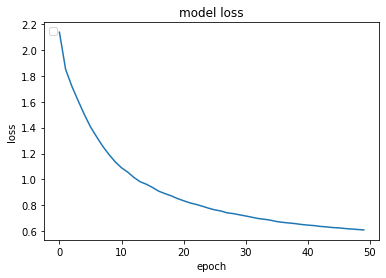

In [18]:
def plot_hist(hist):
    # summarize history for loss
    fig, ax = plt.subplots()  # create figure & 1 axis

    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    plt.plot(hist.history['loss'])
    #plt.plot(hist.history['val_loss'])

plot_hist(hist)

In [0]:
# Predict new Matrix Interactions, set score zero on visualized movies
start_time = time.time()
new_matrix = model.predict(X) * (X == 0)
test_time = time.time() - start_time

In [20]:
new_matrix

array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        -8.9108758e-02,  1.6719997e-01, -1.5027712e-01],
       [ 0.0000000e+00, -2.9360428e-01,  3.2239163e-01, ...,
        -5.4945774e-02,  7.4926071e-02, -1.6292688e-02],
       [ 2.3549275e-01,  2.0008808e-01,  1.3165614e-01, ...,
        -1.5182948e-01, -8.6291716e-02,  9.9895172e-02],
       ...,
       [ 0.0000000e+00,  5.4661352e-02,  2.9063171e-01, ...,
         1.8017450e-01,  1.8293971e-02, -1.2258245e-03],
       [ 1.5746572e+00,  4.1971084e-01,  2.8363037e-01, ...,
         9.3602695e-02,  1.7881966e-01, -1.2272703e-02],
       [ 3.4996316e+00,  0.0000000e+00,  7.9502785e-01, ...,
         6.2499516e-02,  1.2902988e-01, -7.1480349e-02]], dtype=float32)

In [0]:
def metrics_(data_true, data_pred,time_train, time_test):
    mse=np.sqrt(mean_squared_error(data_true, data_pred))
    mae=mean_absolute_error(data_true, data_pred)
    r2=r2_score(data_true, data_pred)
    ex_var=explained_variance_score(data_true, data_pred)
    df=pd.DataFrame({"RMSE": mse, "MAE":mae, "R2_score":r2, "explained variance":ex_var,
                     'train time':time_train, 'test time':time_test},index=[0])
    return df

In [22]:
metrics_(X, new_matrix,train_time, test_time)

,RMSE,MAE,R2_score,explained variance,train time,test time
0,0.997727,0.417863,-0.702004,-0.639927,29.191485,0.219287
